In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools

In [2]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2,2],
                                     n_gaussian_features =2,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)
factored_hidden_states.head()

,0,1
2020-08-01,0,0
2020-08-02,0,0
2020-08-03,0,0
2020-08-04,0,0
2020-08-05,0,0


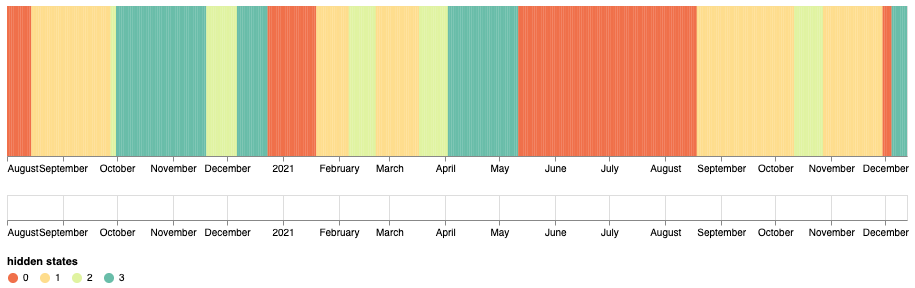

In [3]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

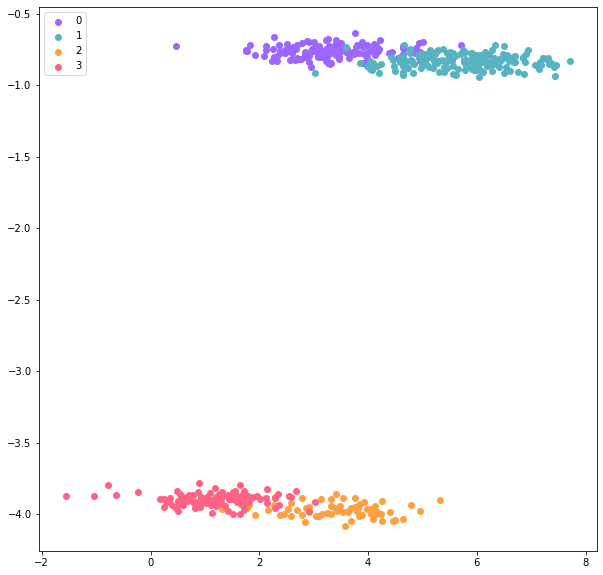

In [4]:
data = gen.generate_observations(factored_hidden_states)

plt.figure(figsize = (10,10))
feat = gen.gaussian_values.columns
for i in range(np.prod(gen.ns_hidden_states)):
    idx = np.where(flattened_hidden_states == i)
    df = np.array(data.loc[data.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = TU_COLORS[i],label = i)

plt.legend()
plt.show()

In [5]:
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
model = fhmm_config.to_model()

In [6]:
inf = model.to_inference_interface(data)

In [8]:
# Gamma, Xi, gibbs_states = inf.gibbs_sampling(data, iterations = 10, burn_down_period = 5, gather_statistics = True)

In [12]:
self = inf
model = self.model
# if hidden_state_vector_df is None:
hidden_state_enum_df = np.random.choice(
        list(model.hidden_state_enum_to_vector.keys()), data.shape[0])
hidden_state_vector_df = pd.DataFrame(
    [
        model.hidden_state_enum_to_vector[v]
        for v in hidden_state_enum_df
    ],
    index=data.index,
    columns=[i for i in range(len(model.ns_hidden_states))]) # df of random choices for hidden states

In [29]:
hidden_state_vector_df 
# Gamma = None
# Xi = None
# gather_statistics = True
# if gather_statistics == True:
#     Gamma = np.zeros((data.shape[0], np.sum(model.ns_hidden_states),
#                       np.sum(model.ns_hidden_states)))
#     Xi = np.zeros((len(model.ns_hidden_states), data.shape[0] - 1,
#                    np.sum(model.ns_hidden_states),
#                    np.sum(model.ns_hidden_states)))
# print(Gamma.shape) #(500, 4, 4)
# print(Xi.shape) #(2, 499, 4, 4)

,0,1
2020-08-01,0,1
2020-08-02,0,1
2020-08-03,1,0
2020-08-04,0,0
2020-08-05,1,0
...,...,...
2021-12-09,1,0
2021-12-10,1,0
2021-12-11,0,0
2021-12-12,0,1


In [17]:
# for r in range(iterations + burn_down_period):
sample_times = np.random.choice(
    [i for i in range(data.shape[0])], data.shape[0], replace=False)
sample_systems = np.random.choice(
    [i for i in range(len(self.model.ns_hidden_states))],
    len(self.model.ns_hidden_states),
    replace=False)
sample_parameter = np.random.uniform(0, 1, data.shape[0])
print(sample_times) # order of timestamps
print(sample_systems) # order of systems
print(sample_parameter) #random number 0 - 500 between 0, 1

[370  85 414 333   5 387 342 483 120  15 311 330 491 106 135 103 472 215
 160  14  62 415 457 312 261 244 374   9 348 199 167 235  16  92 461  55
  54 355 109 268 389 430 277 489 358  27 256  84 287 447 233  37 403 178
 482 418 337 401 130 230  71 327 275 161 486 149 310  25 146 125 270 127
 468  68  49  48 433  87 140 189 227 137 297 123 296 366 368 440 381 102
 492 175 373 451 190 119 148 286 289 251 298 214 104 309 326 334 322  46
 285 132 131 295 385 429 180  98 428 144 207  82 464 365  13 449 198 185
 283 168  94  33 477  73 151 100 166  79  63 126 460 202 292 338  89 420
  66  96 129 255 352  69 467 422 409 490 234 239 122 257  45 441 248 313
 153 371 351 171  51 341 452 243 332  77  32 450  97  29 258 219 329 150
 317 156  67  26  60  81 124  74 391 404 113 158 343 136 434 318 246 331
 222 453 288 114 359 220 128 184 455  53 419  41 324 264 281 421 488 473
 187  20 308 138 306 266 223 290 442 203  22 448 196  50 396 325 236 478
 398  75 379 316 305 353 339 242   7 425 231 228 47

In [18]:
#categorical log emission + logpf(gaussian_data, relevant w@vector, cov)
emission = self.emission_log_probabilities(data) 
emission

,0,1,2,3
2020-08-01,-10.877611,-1.000000e+08,-20.941261,-25.321116
2020-08-02,-15.451742,-2.245262e+01,-20.499358,-27.575138
2020-08-03,-11.110625,-1.000000e+08,-21.257890,-25.671785
2020-08-04,-12.037685,-1.902176e+01,-15.661108,-22.720087
2020-08-05,-15.699170,-1.000000e+08,-27.492199,-32.015797
...,...,...,...,...
2021-12-09,-10.728415,-7.250037e+00,-16.067086,-15.099247
2021-12-10,-15.851212,-1.240252e+01,-23.588003,-22.649853
2021-12-11,-11.602617,-8.223920e+00,-17.439029,-16.570873
2021-12-12,-12.881598,-9.440123e+00,-19.359614,-18.428679


In [21]:
t = sample_times[0]
h_current = (hidden_state_vector_df.iloc[t, :]).to_list()
n_next = None
column_vectors = self.model.vector_to_column_vectors(h_current)
print(h_current) #current hidden state
print(column_vectors) #flattened vector

[1, 1]
[array([[0],
       [1]]), array([[0],
       [1]])]


In [22]:
if t < data.shape[0] - 1:
    h_next = np.array(hidden_state_vector_df.iloc[t + 1, :])
    next_column_vectors = self.model.vector_to_column_vectors(
        h_next)
print(h_next) #next hidden state
print(next_column_vectors) # flattened vector

[1 0]
[array([[0],
       [1]]), array([[1],
       [0]])]


In [ ]:
for m in sample_systems:
    print(sample_systems)
    updated_state_prob = self.probability_distribution_across_hidden_states(
        data,
        current_hidden_state=h_current,
        idx=t,
        system=m,
        emission_log_probabilities=emission,
        next_hidden_state=h_next)
    hidden_state_vector_df.iloc[t, m] = _sample(
        updated_state_prob, sample_parameter[t])

In [7]:
# def gibbs_sampling(self,
#                    data,
#                    iterations,
#                    burn_down_period=100,
#                    gather_statistics=False,
#                    hidden_state_vector_df=None):
#     """ Samples one timestep and fHMM system

#     Arguments: 
#         data: (dataframe) observed timeseries data.
#         iterations: (int) number of rounds of sampling to carry out.
#         burn_down_period: (int) number of iterations for burn down before 
#             gathering statistics.
#         gather_statistics: (bool) indicates whether to gather statistics while 
#             iterating.
#         hidden_state_vector_df: (dataframe) timeseries of hidden state vectors
#             with the same index as "data".  If default "None" is given, then
#             this dataframe will be seeded randomly.

#     Returns: The arrays Gamma and Xi containing statistics, and an updated hidden 
#         state vector
#     """
#     model = self.model

#     # Initialize dataframe of hidden state vectors if none is given.
#     if hidden_state_vector_df is None:
#         hidden_state_enum_df = np.random.choice(
#             list(model.hidden_state_enum_to_vector.keys()), data.shape[0])
#         hidden_state_vector_df = pd.DataFrame(
#             [
#                 model.hidden_state_enum_to_vector[v]
#                 for v in hidden_state_enum_df
#             ],
#             index=data.index,
#             columns=[i for i in range(len(model.ns_hidden_states))])


#     for r in range(iterations + burn_down_period):
#         sample_times = np.random.choice(
#             [i for i in range(data.shape[0])], data.shape[0], replace=False)
#         sample_systems = np.random.choice(
#             [i for i in range(len(self.model.ns_hidden_states))],
#             len(self.model.ns_hidden_states),
#             replace=False)
#         sample_parameter = np.random.uniform(0, 1, data.shape[0])

#         emission = self.emission_log_probabilities(data)

#         for t in sample_times:
#             h_current = (hidden_state_vector_df.iloc[t, :]).to_list()
#             n_next = None
#             column_vectors = self.model.vector_to_column_vectors(h_current)

#             if t < data.shape[0] - 1:
#                 h_next = np.array(hidden_state_vector_df.iloc[t + 1, :])
#                 next_column_vectors = self.model.vector_to_column_vectors(
#                     h_next)

#             for m in sample_systems:

#                 updated_state_prob = self.probability_distribution_across_hidden_states(
#                     data,
#                     current_hidden_state=h_current,
#                     idx=t,
#                     system=m,
#                     emission_log_probabilities=emission,
#                     next_hidden_state=h_next)
#                 hidden_state_vector_df.iloc[t, m] = _sample(
#                     updated_state_prob, sample_parameter[t])

#     return hidden_state_vector_df